### Pokemon unsupervised clustering and feature reduction
Mihai Matei [Data Science]

To have a more common API and limit the size of the notebook I created the matmih utility package (see archive)

In [1]:
# Download some of the required libraries
import sys
def install_modules():
    !pip install --quiet kaggle
    !pip install --quiet randomcolor
    !pip install --quiet pandas
    !pip install --quiet matplotlib
    !pip install --quiet Pillow
    !pip install --quiet scikit-learn
    !pip install --quiet scikit-image
    !pip install --quiet tensorflow-gpu
install_modules()

### Pokemon Dataset processing

#### Download the Pokemon database
Create a kaggle account and an API token 
https://github.com/Kaggle/kaggle-api/blob/master/README.md

In [2]:
%load_ext autoreload
%autoreload
import sys
import os

# Import my own library from local disk or gdrive
GDRIVE_PATH='/content/gdrive/My Drive/master/PractML/Project1/'
if 'google.colab' in sys.modules:
    from google.colab import drive
    import shutil
    drive.mount('/content/gdrive')
    sys.path.append(GDRIVE_PATH)
    os.makedirs('/root/.kaggle/', exist_ok=True)
    shutil.copyfile(GDRIVE_PATH + 'kaggle.json', '/root/.kaggle/kaggle.json')
    !chmod 600 '/root/.kaggle/kaggle.json'

# My own library
import matmih as mm

# Download the pokemon kaggle database
if not os.path.isfile('./data/pokemon.csv'):
    import kaggle
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('vishalsubbiah/pokemon-images-and-types', path='./data', unzip=True)

#### Pokemon data set
Load the Pokemon data set and all the images in the directory. Create a target column as a panda category type

In [3]:
import numpy as np
import pandas as pd

pDF = pd.read_csv('./data/pokemon.csv', delimiter=',')
pDF.dataframeName = 'pokemon.csv'
IMAGE_SIZE = (128,128)


def load_images(df):
    imgUrls = df.apply(lambda row: './data/images/images/' + row['Name'].lower(), axis=1)
    df['ImageURL'] = imgUrls.apply(lambda row: row + '.png' if os.path.isfile(row + '.png') else row + '.jpg')

    df['target'] = df['Type1'].astype('category')
    df['features'] = df['ImageURL'].apply(lambda row: mm.Image.load(row, size=IMAGE_SIZE))

    return df

pDF = load_images(pDF)
pDF.describe()

,Name,Type1,Type2,ImageURL,target,features
count,809,809,405,809,809,809
unique,809,18,18,809,18,809
top,clauncher,Water,Flying,./data/images/images/gumshoos.jpg,Water,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
freq,1,114,95,1,114,1


##### Pokemon Type histograms
Lets take a quick look at the dataset and the class distribution. Notice that some classes are predominant in Type I and others in Type II columns.

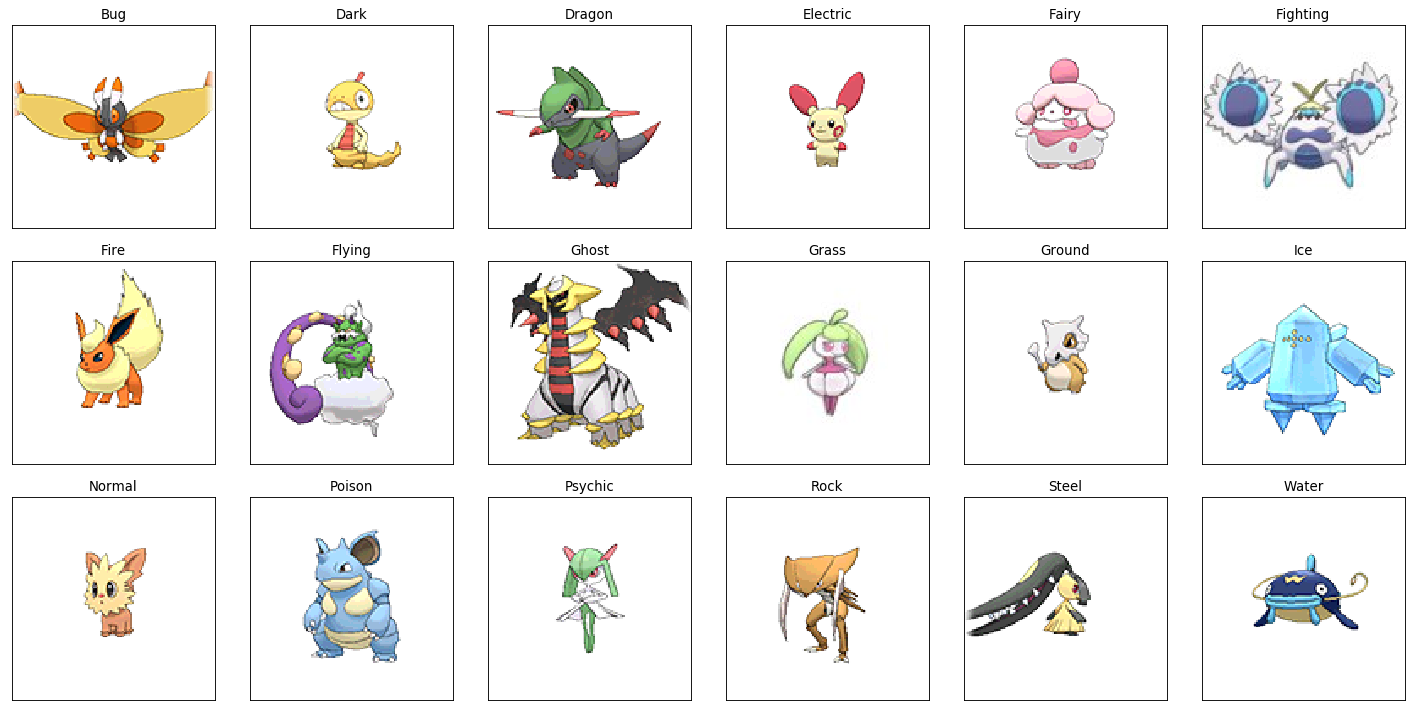

Pokemon class targets: ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']


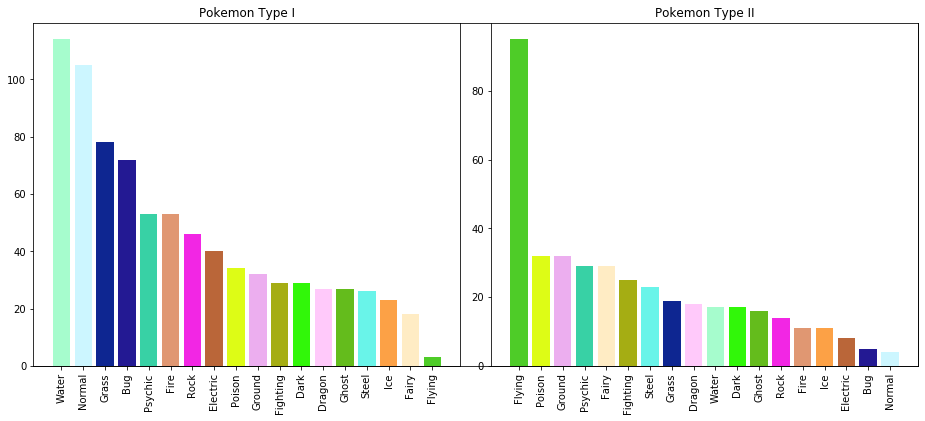

In [4]:
import random
from datetime import datetime
# Seed the pseudo random number generator
random.seed(datetime.now())

def show_random_pokemons(df):
    images = []
    titles = []
    # show a pokemon for each class
    for cl in df['target'].cat.categories:
        class_df = df[df['target'] == cl]
        idx = random.randrange(len(class_df))
        titles.append(class_df['Type1'].iloc[idx])
        images.append(class_df['ImageURL'].iloc[idx])

    mm.PlotBuilder().create_images(images, titles).show()

show_random_pokemons(pDF)

print("Pokemon class targets: {}".format(pDF['target'].cat.categories.to_list()))
mm.PlotBuilder().create_histograms([pDF['target'], pDF['Type2'].astype('category')],
                                   ['Pokemon Type I', 'Pokemon Type II']).show()

#### Pokemon type augmentation
To augment the dataset we also duplicate the Type II column as a new Type I entry that has the original image rotate by 20 degrees.

Since we are using unsupervised models we keep the entire data in the training set.

Plot the distribution of the entire training data

Train size: 1214


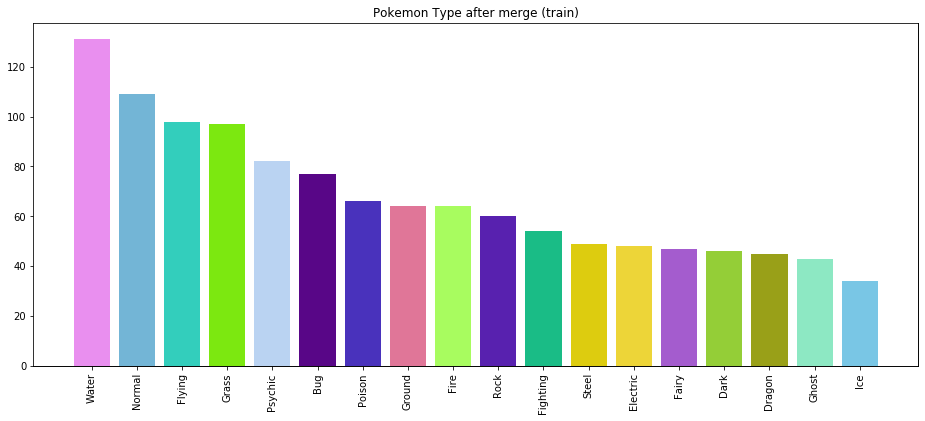

In [5]:
# We are augmenting the dataset by adding the pokemons that have the second type set up as well
def add_second_type_pokemons(ds):
    from scipy.ndimage.interpolation import rotate

    type2_pok = ds[ds['Type2'].isnull() == False].copy()
    # rotate the feature images to createa a new feature set as well
    type2_pok['features'] = type2_pok['features'].apply(lambda image: rotate(image, angle=20, cval=255, reshape=False))
    # set Type2 as the new target class
    type2_pok['target'] = raw_cat = pd.Categorical(type2_pok['Type2'], categories=ds['target'].cat.categories)

    # append assigning new index to each new row in type2_pok
    return pd.concat([ds, type2_pok], ignore_index=True)

# Create the dataset from the panda dataframe
data_set = mm.DataSet(pDF, feature_column='features', target_column='target')

# No validation or test split
data_set.split_data((1.0, 0., 0.), shuffle=False, augment_callback=add_second_type_pokemons)

print("Train size: {}".format(len(data_set.train_target)))
mm.PlotBuilder().create_histograms([data_set.train_target], ['Pokemon Type after merge (train)']).show()

### Feature selection and reduction
#### Data normalization

The below PCA method does not work for our 49152 features so we reduce it to 10000 using Anova filtering
* flatten the feature vectors
* normlize to mean 0 and std 1 (PCA works much better with normalized features)
* run a constant and anova filter to get top X


In [6]:
DATA_MODELS = {}
DATA_MODELS['original'] = mm.ModelDataSet(data_set)

# First feature set we will be using comes from the original image features normalized and anova filtered using top 10000
DATA_MODELS['anova'] = mm.DataModel(DATA_MODELS['original'].train_features, DATA_MODELS['original'].train_target)
DATA_MODELS['anova'] = DATA_MODELS['anova'].flatten().normalize().filter(10000)

### Principal Component Analysis
Model implementation using scikit-learn library. The number of components and solver are hyperparameters

In [7]:
import sklearn as sk

class PCAModel(mm.SklearnModel):
    def __init__(self, **hyper_params):
        self.Ncomponents = hyper_params.get('components', len(DATA_MODELS['original'].classes))
        self.solver = hyper_params.get('solver', 'full')

        model = sk.decomposition.PCA(n_components=self.Ncomponents, svd_solver=self.solver)
    
        super(PCAModel, self).__init__(model, checkpoint=False)

    def train(self, data_model, log=False):

        self._model.fit(data_model.train_features)

        return {
            'Component variance' : self._model.explained_variance_,
            'Explained variance' : np.sum(self._model.explained_variance_),
            'Log likelihood' : self._model.score(data_model.train_features)
        }
    
    def predict(self, features):
        return self._model.transform(features), self._model.score(features)
    
    def reverse(self, features):
        return self._model.inverse_transform(features)

#### PCA hyperparameter seach
Run PCA on the training set filtered with Anova with 10000 features.

Store the PCA representation of the training set as new data models to be used later.

Compute and plot several metrics for each PCA such as the variance or the log likelihood or the R squared or Mean squared error of the reconstructed features.


In [8]:
PCA_COMPONENTS = [2, 3, 18, 64, 100, 1000]

# Search the hyperparameter space for the best model
pcaLookup = mm.HyperParamsLookup(lambda hyper_params: PCAModel(**hyper_params),
                                 lambda hist: np.sum(hist['Explained variance']))

pcaLookup.grid_search(DATA_MODELS['anova'], True, False, components=PCA_COMPONENTS)

pca_r2 = []
pca_mse = []
# compute the features for all PCAs
for i, comp in enumerate(PCA_COMPONENTS):
    pca_name = 'PCA N={}'.format(comp)
    # compute the PCA transformed features
    features, _ = pcaLookup.models[i].predict(DATA_MODELS['anova'].train_features)
    DATA_MODELS[pca_name] =  mm.DataModel(features, DATA_MODELS['anova'].train_target)

    # and the reversed PCA transformed features and error metrics
    reverse_features = pcaLookup.models[i].reverse(DATA_MODELS[pca_name].train_features)
    pca_r2.append(sk.metrics.r2_score(DATA_MODELS['anova'].train_features, reverse_features))
    pca_mse.append(sk.metrics.mean_squared_error(DATA_MODELS['anova'].train_features, reverse_features))

Hyperparameters: {'components': 2}
Results: 1936.3167470630492
Hyperparameters: {'components': 3}
Results: 2307.691832230082
Hyperparameters: {'components': 18}
Results: 4628.673686052438
Hyperparameters: {'components': 64}
Results: 6541.344206442325
Hyperparameters: {'components': 100}
Results: 7212.959600847214
Hyperparameters: {'components': 1000}
Results: 9948.340469738181


#### PCA metrics plots

- Plot the reconstructed Anova filtered image of each PCA model
- Plot the above recorded metrics. Notice that the explained variance increases as well as the log likelihood as the PCA components increases.
- $R^2$ for the reconstructed image is the same, but differently scaled, as Expained Variance.
- MSE also decreases with increasing the number of components

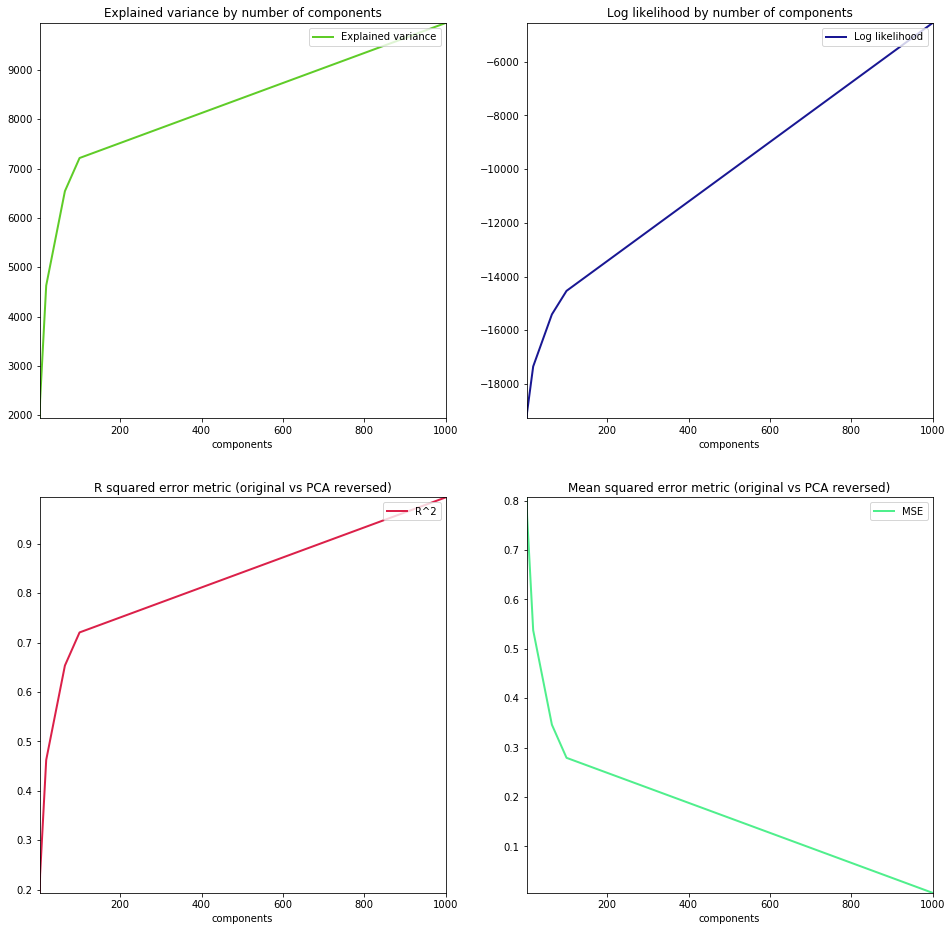

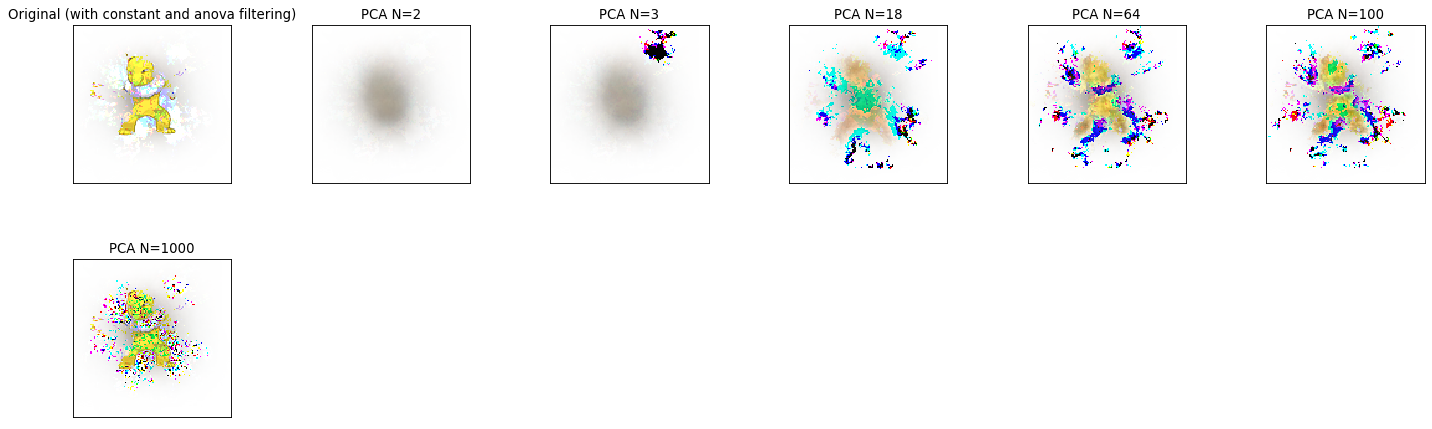

In [11]:
# Show a per epoch training history
def show_training_history(plot_builder, histories, x_metric, y_metrics, title):
    """Plots multiple metrics of model's histories found in hyperparameter search"""
    to_plot = [[] for _ in range(len(y_metrics))]
    X = []
    for hyper_params, history in histories:
        X.append(hyper_params[x_metric])
        for i, metric in enumerate(y_metrics):
            to_plot[i].append(history[metric])

    plot_builder.create_plot(title, (X, x_metric), *zip(to_plot, y_metrics))

def show_pca_pokemons(plot_builder, data_model, models, components):
    """Reconstructs the images under PCA transformation"""
    def reconstruct(features):
        return data_model.unflatten(data_model.unormalize(data_model.unfilter(features)))
    def get_image(features):
        return reconstruct(features)[0].astype(np.uint8)

    images = []
    titles = []
    features = data_model.train_features[ random.randrange(len(data_model.train_features)) ]
    features = features[np.newaxis,:]
    
    titles.append('Original (with constant and anova filtering)')
    images.append(get_image(features))
    titles += ['PCA N={}'.format(c) for c in components]
    images += [get_image(m.reverse(m.predict(features)[0])) for m in models]

    plot_builder.create_images(images, titles)

PB = mm.PlotBuilder().create_subplots(2, 2, fig_size=(16, 16))
show_training_history(PB, pcaLookup.history, 'components', ['Explained variance'], 'Explained variance by number of components')
show_training_history(PB, pcaLookup.history, 'components', ['Log likelihood'], 'Log likelihood by number of components')
PB.create_plot('R squared error metric (original vs PCA reversed)', (PCA_COMPONENTS, 'components'), (pca_r2, 'R^2'))
PB.create_plot('Mean squared error metric (original vs PCA reversed)', (PCA_COMPONENTS, 'components'), (pca_mse, 'MSE'))
show_pca_pokemons(PB, DATA_MODELS['anova'], pcaLookup.models, PCA_COMPONENTS)
PB.show()

#### Pokemon feature distribution
Plot the 2d and 3d resulting features for applying PCA with 2 or 3 components as well as the original but normalized Anova filtered features.

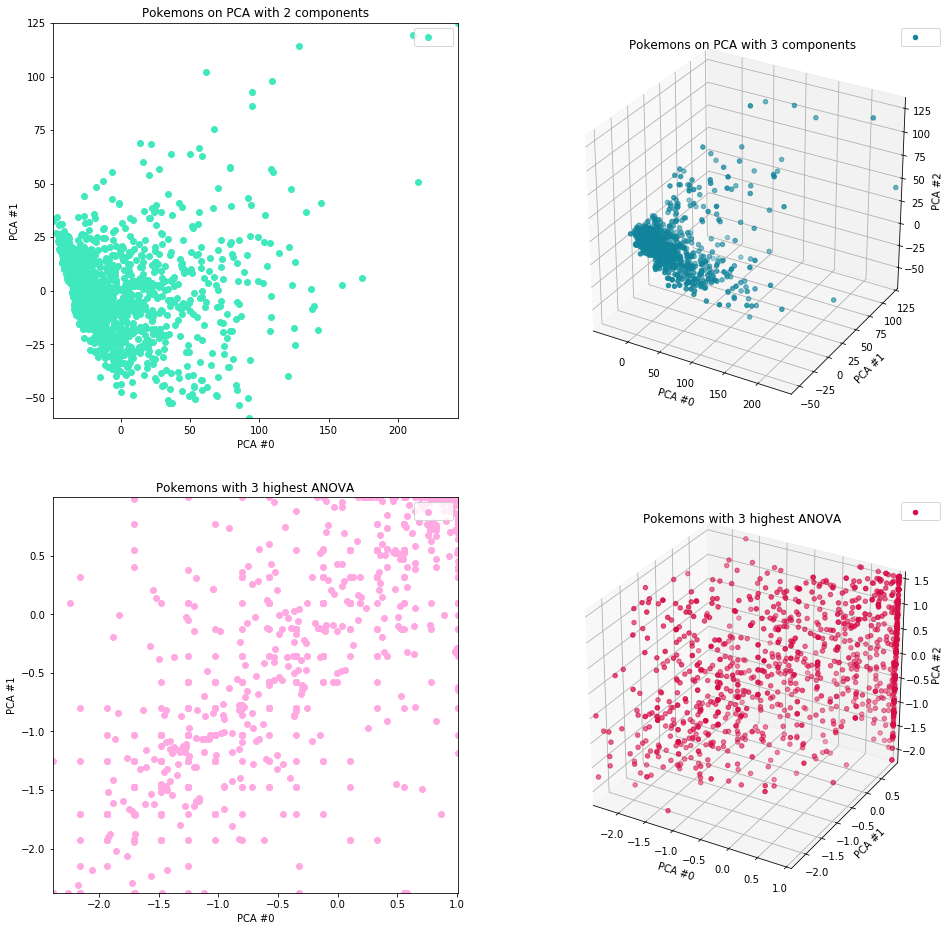

In [12]:
PB = mm.PlotBuilder().create_subplots(2, 2, fig_size=(16, 16))

PB.create_scatter_plot('Pokemons on PCA with 2 components', ['PCA #0', 'PCA #1'],
                                     (DATA_MODELS['PCA N=2'].train_features[:, 0],
                                      DATA_MODELS['PCA N=2'].train_features[:, 1], ' '))
PB.create_scatter_plot('Pokemons on PCA with 3 components', ['PCA #0', 'PCA #1', 'PCA #2'],
                                     (DATA_MODELS['PCA N=3'].train_features[:, 0],
                                      DATA_MODELS['PCA N=3'].train_features[:, 1],
                                      DATA_MODELS['PCA N=3'].train_features[:, 2], ' '))

DATA_MODELS['anova_3'] = mm.DataModel(DATA_MODELS['original'].train_features, DATA_MODELS['original'].train_target)
DATA_MODELS['anova_3'] = DATA_MODELS['anova_3'].flatten().normalize().filter(3)
PB.create_scatter_plot('Pokemons with 3 highest ANOVA', ['PCA #0', 'PCA #1'],
                                     (DATA_MODELS['anova_3'].train_features[:, 0],
                                      DATA_MODELS['anova_3'].train_features[:, 1], ' '))
PB.create_scatter_plot('Pokemons with 3 highest ANOVA', ['PCA #0', 'PCA #1', 'PCA #2'],
                                     (DATA_MODELS['anova_3'].train_features[:, 0],
                                      DATA_MODELS['anova_3'].train_features[:, 1],
                                      DATA_MODELS['anova_3'].train_features[:, 2], ' ')).show()


### Histogram of oriented gradients
Use a HOG feature selection to extract additional data model features. The pixels per cell and cells per block are also hyperparameters to the model

Plot the HOG image of an original Pokemon.

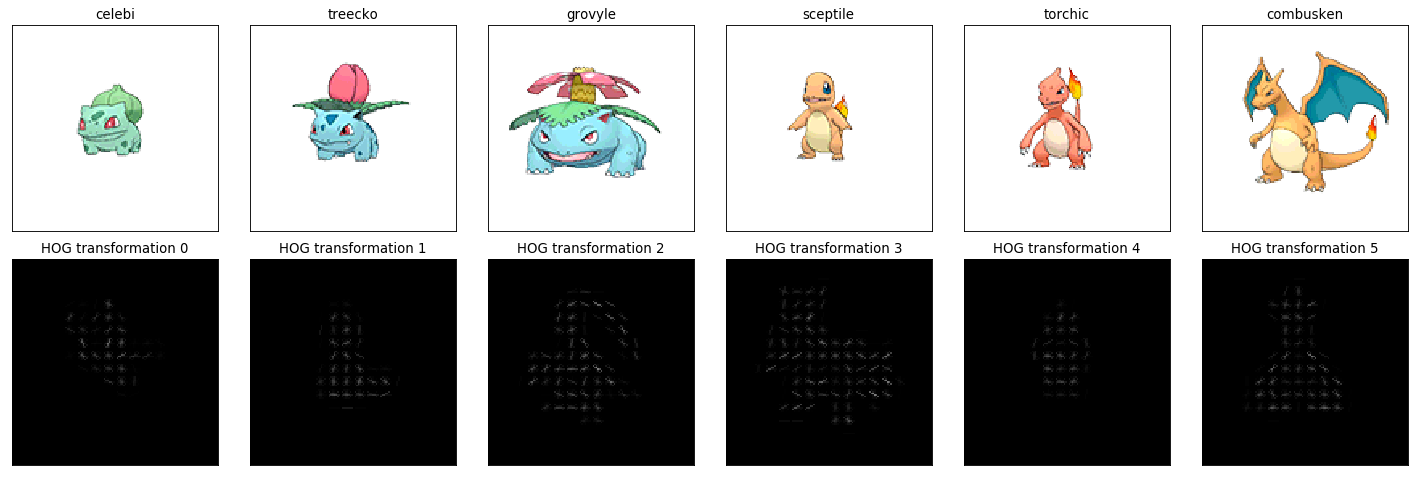

In [13]:
from skimage.feature import hog
class HOGModel(mm.SklearnModel):
    def __init__(self, **hyper_params):
        self.orientations = hyper_params.get('orientations', 9)
        self.pixels_per_cell = hyper_params.get('pixels_per_cell', (8, 8))
        self.cells_per_block = hyper_params.get('cells_per_block', (3, 3))
        self.visualize = hyper_params.get('visualize', False)

        model = lambda data: hog(data,
                                orientations=self.orientations,
                                pixels_per_cell=self.pixels_per_cell,
                                cells_per_block=self.cells_per_block,
                                visualize=self.visualize, multichannel=True, feature_vector=True)

        super(HOGModel, self).__init__(model)

    def train(self, data_model, log=False):
        pass
    
    def predict(self, features):
        features_hogs = []
        hogs_images = []
        for feature in features:
            if self.visualize:
                feat_hog, image_hog = self._model(feature)
                hogs_images.append(image_hog)
            else:
                feat_hog = self._model(feature)
            features_hogs.append(feat_hog)
        return np.vstack(features_hogs), hogs_images

def show_hog_images(data_set, df):
    import matplotlib.pyplot as plt
    idx = random.randrange(len(df) - 6)
    hogModel = HOGModel(visualize=True)
    _, hogs_images = hogModel.predict([data_set.train_features[i] for i in range(idx, idx + 6)])
    titles = [df['Name'].iloc[i] for i in range(idx, idx + 6)]
    titles += ['HOG transformation {}'.format(i) for i in range(6)]
    images = [data_set.train_features[i] for i in range(6)]
    mm.PlotBuilder().create_images(images+hogs_images, titles, cmap=plt.cm.gray).show()

show_hog_images(data_set, pDF)

HOG_PIXEL_CELL = [(8,8), (16,16), (32,32)]
# compute the features for all HOGs
for i, pixels_per_cell in enumerate(HOG_PIXEL_CELL):
    features, _ = HOGModel(pixels_per_cell=pixels_per_cell).predict(DATA_MODELS['original'].train_features)
    DATA_MODELS['HOG PIXEL_CELL={}'.format(pixels_per_cell)] =  mm.DataModel(features, DATA_MODELS['original'].train_target)

### CNN model feature extraction
Use transfer learning to create a CNN Model starting from MobileNetV2 trained on imagenet and get the resulting feature vector prior to the last dense layer used for classification.

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

class FeatureCNNModel(mm.TensorModel):
    from abc import abstractmethod
    BATCH_SIZE = 32
    INPUT_SHAPE = (128, 128, 3)
    
    @abstractmethod
    def get_cnn_model(self, hyper_params):
        pass

    def __init__(self, hyper_params):
        super(FeatureCNNModel, self).__init__(self.get_cnn_model(hyper_params), checkpoint=False)

    def train(self, data_model):
        """The model is already pre-trained on imagenet features"""
        return None

    def predict(self, features):
        features_ds = tf.data.Dataset.from_tensor_slices(tf.cast(features, tf.float32)).batch(FeatureCNNModel.BATCH_SIZE)
        result = []
        for batch in features_ds:
            result.append(self._model(batch).numpy())

        return np.concatenate(result, axis=0)

class MobileNetV2Model(FeatureCNNModel):
    def get_cnn_model(self, hyper_params):
        # Create the base model from the pre-trained model MobileNet V2
        return tf.keras.applications.MobileNetV2(input_shape=FeatureCNNModel.INPUT_SHAPE,
                                                 include_top=False, weights='imagenet', pooling='avg')

    def __init__(self, **hyper_params):
        super(MobileNetV2Model, self).__init__(hyper_params)
        

# Predict the features using MobileNetV2
DATA_MODELS['CNN - MobileNet'] =  mm.DataModel(MobileNetV2Model().predict(
                                                    # normalize the dataset prior to prediction https://arxiv.org/abs/1801.04381
                                                    mm.ModelDataSet(data_set).normalize_MobileNetV2().train_features),
                                               DATA_MODELS['original'].train_target)

Num GPUs Available:  0


### Cluster feature sets
Show the current selected and preprocessed feature sets to use in the clustering part of the project.

Normalize all data.

In [15]:
print('{:>25}{:>20}'.format('Feature selection', 'Feature Size'))
for name, data in DATA_MODELS.items():
    print('{:>25}{:>20}'.format(name, np.prod(data.train_features.shape[1:])))
    if name != 'original':
        data.flatten().normalize()

        Feature selection        Feature Size
                 original               49152
                    anova               10000
                  PCA N=2                   2
                  PCA N=3                   3
                 PCA N=18                  18
                 PCA N=64                  64
                PCA N=100                 100
               PCA N=1000                1000
                  anova_3                   3
    HOG PIXEL_CELL=(8, 8)               15876
  HOG PIXEL_CELL=(16, 16)                2916
  HOG PIXEL_CELL=(32, 32)                 324
          CNN - MobileNet                1280


### Cluster models
Implement an abstract Cluster class using mm.Model API. Test them against the normalized feature sets learned in the previous section.

The following cluster metrics as being computed:

**1) Unsupervised metrics**
* **Silhouette Coefficient** - a higher Silhouette Coefficient score relates to a model with better defined clusters
* **Calinski-Harabasz Index** - known as Variance Ratio Criterion and higher score relates to a model with better defined clusters
* **Davies-Bouldin Index** - signifies the average similarity between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. Values closer to zero indicate a better partition

**2) Supervised metrics**

This can be constructed when the true value of the cluster are known. I will use the Pokemon type information from the original data set as the truth value. Since the labes are between 0-17 (18 classes) some metrics might be monotonous.
* **Adjusted Rand index** - measures the similarity of the two assignments, ignoring permutations and with chance normalization. Between [-1, 1] negative values signifies independent labeling, similar clustering have a positive ARI.
* **Normalized Mutual Information** - used in clustering literature. Between [0, 1] values close to zero indicate two label assignments that are largely independent, while values close to one indicate significant agreement. 
* **Homogeneity** - each cluster contains only members of a single class, between [0, 1] with greater values signifies better assignment
* **Completeness** - all members of a given class are assigned to the same cluster, [0, 1] with greater values signifies better assignment
* **V-measure** - harmonic measure of Homogeneity and Completeness $\frac {2*H*C}{H+C}$.
* **Fowlkes-Mallows scores** - uses classification metrics such as TP, FN to compute the index, between [0, 1]. A high value indicates a good similarity between two clusters.
* **Outliers** - measure the number of samples that are not part of any cluster (especially for DBSCAN)

#### Accuracy measurement
An important aspect of measuring cluster performance is to use the supervised measure of accuracy. For a cluster assignment this is hard to compute as we do not know how to assign the cluster identifier to an actually true label. There is also the problem that the cluster numbers can be greater that the cluster labels and hance a classification label can be assigned to multiple clusters. I implemented the following algorithm:
* measure the contingency matrix for each true label to each predicted clusters. It will have the shape TLxPC where TL is the number of true labels(18 in our case) and PC the numbr of clusters. $C_{i,j}$ represents the number of i true labels present in cluster j. A column will sum up to the number of cluster assigned to predicted cluster, where a row will sum up to the total true labels of that class in the set.
* Compute the maximum assignment between the true labels and the predicted cluster. Consider the true labels and the predicted labels as a bipartite graph (TL on the left, PC on the right). The maximum assignment is the maximum weighted matching between the 2 graphs which can be solved efficiently by applying Koning's theorem which specifies that it is equal to the minimum vertex cover. This is solved using the Hungarian method implemented in scipy.optimize.linear_sum_assignment using the negative contingency matrix as a cost matrix
* The above assignment has shape TLxTL (18x18) since we are assigning a true label to a single cluster. In order to do this for all the predicted cluster we remove the samples that have been computed in this step (the samples that belong to the matching clusters) and repeat the process for the remaining clusters and true labels of the remaining samples.
* All the resulting matching total costs is being sum up and divided by the number of samples to get the accuracy metric

In [16]:
# The features that will be used
FEATURE_SETS =['PCA N=18', 'PCA N=100', 'PCA N=1000',
               'HOG PIXEL_CELL=(8, 8)', 'HOG PIXEL_CELL=(32, 32)', 'CNN - MobileNet']

class ClusterModel(mm.SklearnModel):
    from abc import abstractmethod

    @abstractmethod
    def get_cluster_model(self, hyper_params):
        pass

    def __init__(self, hyper_params):
        super(ClusterModel, self).__init__(self.get_cluster_model(hyper_params), checkpoint=False)

    @staticmethod
    def supervised_metrics(true_clusters, predicted_clusters):
        return {
            'Adjusted Rand index' : sk.metrics.adjusted_rand_score(true_clusters, predicted_clusters),
            'Normalized Mutual Information' : sk.metrics.normalized_mutual_info_score(true_clusters, predicted_clusters),
            'Homogeneity' : sk.metrics.homogeneity_score(true_clusters, predicted_clusters),
            'Completeness' : sk.metrics.completeness_score(true_clusters, predicted_clusters),
            'V-measure' : sk.metrics.v_measure_score(true_clusters, predicted_clusters),
            'Fowlkes-Mallows scores' : sk.metrics.fowlkes_mallows_score(true_clusters, predicted_clusters),
        }
    
    @staticmethod
    def accuracy(true_labels, predicted_labels):
        import scipy
        """Resolve the bipartite graph maximum weight matching problem==min weight vertex cover (Koning)
        The computed cost matrix is the full bipartite graph weights true_labels x predicted_labels (NxN)
        The linear sum assignment problem (Hungarian algorithm) is also known as minimum weight matching in bipartite graphs"""
        total_samples = len(true_labels)
        total_predictions = 0
        compute_bipartite = True
        while compute_bipartite:
            cm = sk.metrics.cluster.contingency_matrix(true_labels, predicted_labels)
            cost_matrix = -cm + np.max(cm)

            row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix)
            # compute the sum of the correct predictions from the original contingency matrix
            # since the cost of the assignment can be computed as cost_matrix[row_ind, col_ind].sum()
            total_predictions += cm[row_ind, col_ind].sum()

            current_size = len(predicted_labels)
            # remove the assigned cluster to true labels and recompute
            for cluster_id in col_ind:
                idx_to_del = predicted_labels != cluster_id
                predicted_labels = predicted_labels[idx_to_del]
                true_labels = true_labels[idx_to_del]
            # stop when no assignment is possible
            if current_size >= len(predicted_labels):
                compute_bipartite = False

        # divide by the total number of samples to get the accuracy
        return total_predictions / total_samples

    @staticmethod
    def outliers(predicted_labels):
        return np.sum(predicted_labels==-1)
        
    def train(self, data_model, log=False):
        train_clusters = self._model.fit_predict(data_model.train_features)
        self.train_features = data_model.train_features

        return {
            'Silhouette Coefficient' : sk.metrics.silhouette_score(data_model.train_features, train_clusters, metric='euclidean'),
            'Calinski-Harabasz Index' : sk.metrics.calinski_harabasz_score(data_model.train_features, train_clusters),
            'Davies-Bouldin Index' : sk.metrics.davies_bouldin_score(data_model.train_features, train_clusters)
        }

### KMeans clustering
Apply Kmeans on the above selected feature sets for a multitude of number of clusters.

Compute the sum of the distance between each cluster center and each sample as well as the score of the model, given by the inertia value. The above 2 will be used for the Elbow method.

In [17]:
# number of clusters        
KMEAN_CLUSTER_SIZE = [10, 18, 32, 64, 128]

class KmeansModel(ClusterModel):
    def get_cluster_model(self, hyper_params):
        from sklearn.cluster import KMeans
        self.clusters = hyper_params['clusters']

        return KMeans(n_clusters=self.clusters, random_state=0, n_jobs=-1)

    def __init__(self, **hyper_params):
        super(KmeansModel, self).__init__(hyper_params)

    def train(self, data_model, log=False):
        from scipy.spatial.distance import cdist

        metrics = super(KmeansModel, self).train(data_model, log)
        metrics.update({
            'Distance' : np.sum(np.min(cdist(data_model.train_features,
                                             self._model.cluster_centers_, 'euclidean'),
                                       axis=1)) / len(data_model.train_features),
            'Score' : -self._model.score(data_model.train_features)
        })
        return metrics
    
    def predict(self, features):
        return self._model.predict(features), self._model.score(features)

# normalize the data sets
for feature_set in FEATURE_SETS:
    DATA_MODELS[feature_set].flatten().normalize()

kMeansLookup = {}
# Search the hyperparameter space for the best model
for feature_set in FEATURE_SETS:
    print('--------Kmeans {}-------'.format(feature_set))
    kMeansLookup[feature_set] = mm.HyperParamsLookup(lambda hyper_params: KmeansModel(**hyper_params),
                                                     lambda hist: hist['Distance'])
    kMeansLookup[feature_set].grid_search(DATA_MODELS[feature_set], True, False, clusters=KMEAN_CLUSTER_SIZE)

--------Kmeans PCA N=18-------
Hyperparameters: {'clusters': 10}
Results: 3.177435945343711
Hyperparameters: {'clusters': 18}
Results: 2.9477480612313833
Hyperparameters: {'clusters': 32}
Results: 2.7533552218732877
Hyperparameters: {'clusters': 64}
Results: 2.4703690085107035
Hyperparameters: {'clusters': 128}
Results: 2.121519803218986
--------Kmeans PCA N=100-------
Hyperparameters: {'clusters': 10}
Results: 8.643494316614348
Hyperparameters: {'clusters': 18}
Results: 8.505661438619544
Hyperparameters: {'clusters': 32}
Results: 8.241381624155197
Hyperparameters: {'clusters': 64}
Results: 7.68163874079751
Hyperparameters: {'clusters': 128}
Results: 6.7807440192939525
--------Kmeans PCA N=1000-------
Hyperparameters: {'clusters': 10}
Results: 31.071077312165624
Hyperparameters: {'clusters': 18}
Results: 30.85866015593326
Hyperparameters: {'clusters': 32}
Results: 30.47826003579548
Hyperparameters: {'clusters': 64}
Results: 29.581514546291842
Hyperparameters: {'clusters': 128}
Results:

#### Kmeans unsupervised metrics
Plot the unsupervised metrics for each feature set against the performance with differnet number of clusters.

The score and distance metric can be used to do the Elbow method. It should have the elbow where the Silhoutte coefficiente is high

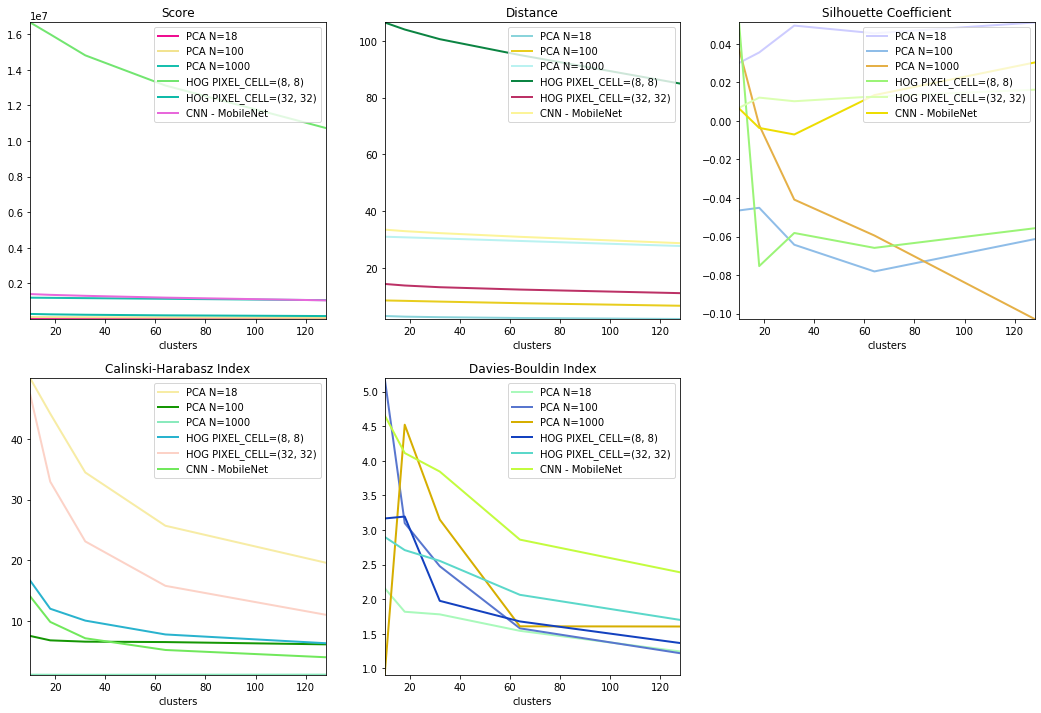

In [18]:
# Show a per epoch training history
def show_group_training_history(plot_builder, clusterLookups, x_metric, y_metric, title):
    """Plots multiple metrics of model's histories found in hyperparameter search"""
    Y = []
    X = []
    # first get the common X metric from the first lookup
    for hyper_params, _ in next(iter(clusterLookups.values())).history:
        X.append(hyper_params[x_metric])
    # for all model lookups get the Y metric
    for data_name, lookup in clusterLookups.items():
        to_plot = []
        for _, history in lookup.history:
            to_plot.append(history[y_metric])
        Y.append((to_plot, data_name))

    plot_builder.create_plot(title, (X, x_metric), *Y)

PB = mm.PlotBuilder().create_subplots(2, 3, fig_size=(18, 12))
for metric in ['Score', 'Distance', 'Silhouette Coefficient', 'Calinski-Harabasz Index', 'Davies-Bouldin Index']:
    show_group_training_history(PB, kMeansLookup, 'clusters', metric, metric)
PB.show()

#### Kmeans supervised metrics
Plot the supervised metrics for each feature set against the true Pokemon types in the original set.

Accuracy is also ploted against the random classifier as well as the SVM and CNN model supervised classifiers learned in Project 1.

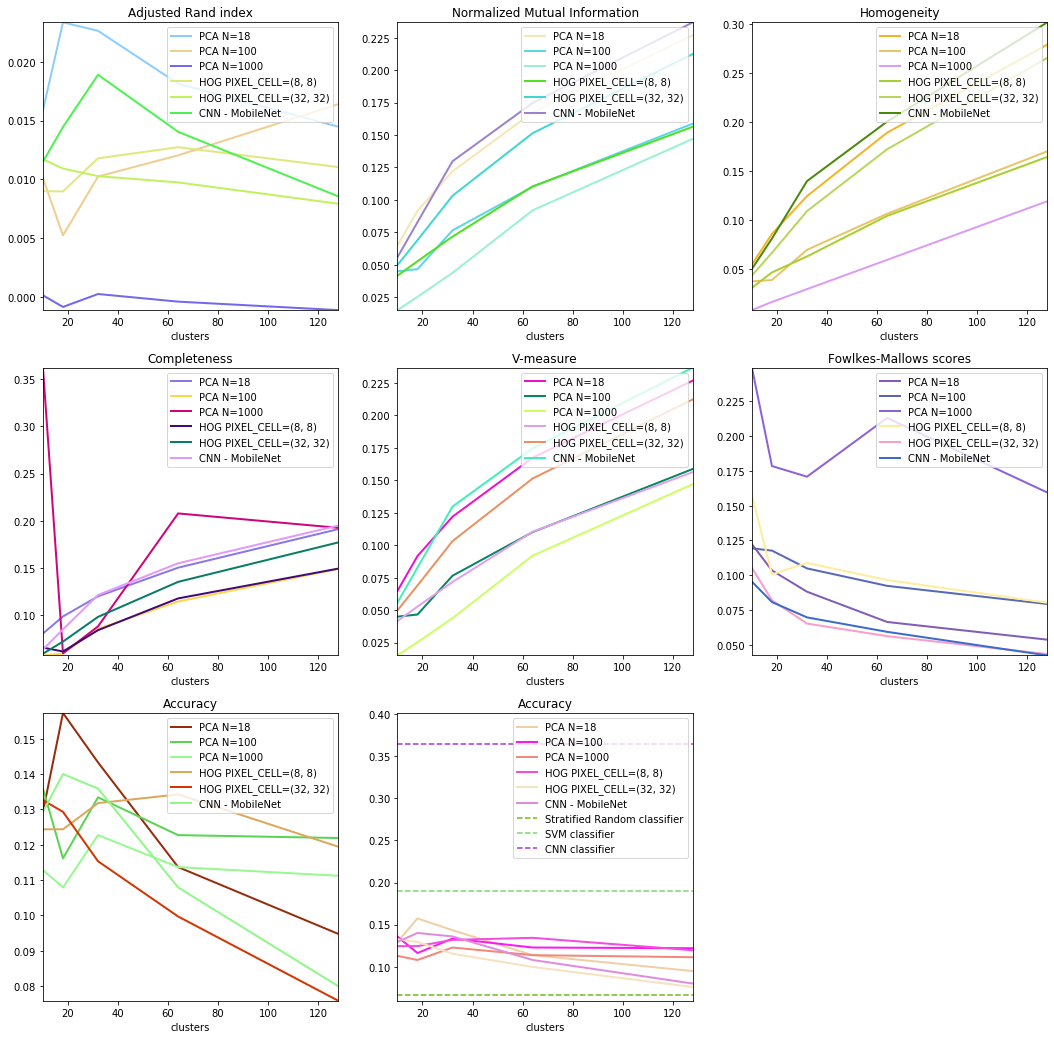

In [19]:
def compute_supervised_metrics(clusterLookups, initial_true_labels):
    """Compute the supervised metrics of all models in clusterLookups
    by taking the true labels iteratively from the cluster predictions of the previous step"""
    # for all model lookups on different data
    for data_name, lookup in clusterLookups.items():
        true_labels = initial_true_labels
        # for all models in the lookup
        for model, (_, history) in zip(lookup.models, lookup.history):
            predicted_labels, _ = model.predict(DATA_MODELS[data_name].train_features)
            metrics = ClusterModel.supervised_metrics(true_labels, predicted_labels)
            history.update(metrics)
            # also compute the accuracy
            history.update({'Accuracy' : ClusterModel.accuracy(true_labels, predicted_labels)})
            # also compute the outliers
            history.update({'Outliers' : ClusterModel.outliers(predicted_labels)})

compute_supervised_metrics(kMeansLookup, DATA_MODELS['original'].train_target)

PB = mm.PlotBuilder().create_subplots(3, 3, fig_size=(18, 18))
for metric in ['Adjusted Rand index', 'Normalized Mutual Information', 'Homogeneity',
               'Completeness', 'V-measure', 'Fowlkes-Mallows scores', 'Accuracy', 'Accuracy']:
    show_group_training_history(PB, kMeansLookup, 'clusters', metric, metric)
PB.same().create_horizontal_line((0.066, 'Stratified Random classifier'),
                                 (0.19, 'SVM classifier'), (0.365, 'CNN classifier'),
                                 linestyle='--')
PB.show()

### DBSCAN model
Implement the scikit-learn dbscan model using the distance and the minimum samples to form a core node as the model's parameter. The model does not have a predict method hence the API always returns the cluster found on the train set

In [20]:
class DBSCANModel(ClusterModel):
    def get_cluster_model(self, hyper_params):
        from sklearn.cluster import DBSCAN
        self.epsilon = hyper_params['epsilon']
        self.core_cluster_size = hyper_params['core_cluster_size']

        return DBSCAN(eps=self.epsilon, min_samples=self.core_cluster_size, metric='euclidean', n_jobs=-1)
    
    @staticmethod
    def get_all_distances(features):
        from scipy.spatial.distance import cdist
        return cdist(features, features, 'euclidean')

    def __init__(self, **hyper_params):
        super(DBSCANModel, self).__init__(hyper_params)
        

    def predict(self, features):
        assert(np.all(features==self.train_features))
        return self._model.labels_, None

### DBSCAN distance and min samples selection
* For different number of minimum samples K plot the minimum Kth distance of each sample to the the other samples
* Select the number of samples and distance (epsilon) where the plot has the biggest difference in a slope. To do this we analyze the gradient of the resulting plot and get some epsilon values near that value
* The resulting K min samples will be the same but the epsilon values chosen will be around the best values. Each feature set will have different K and epsilon lists

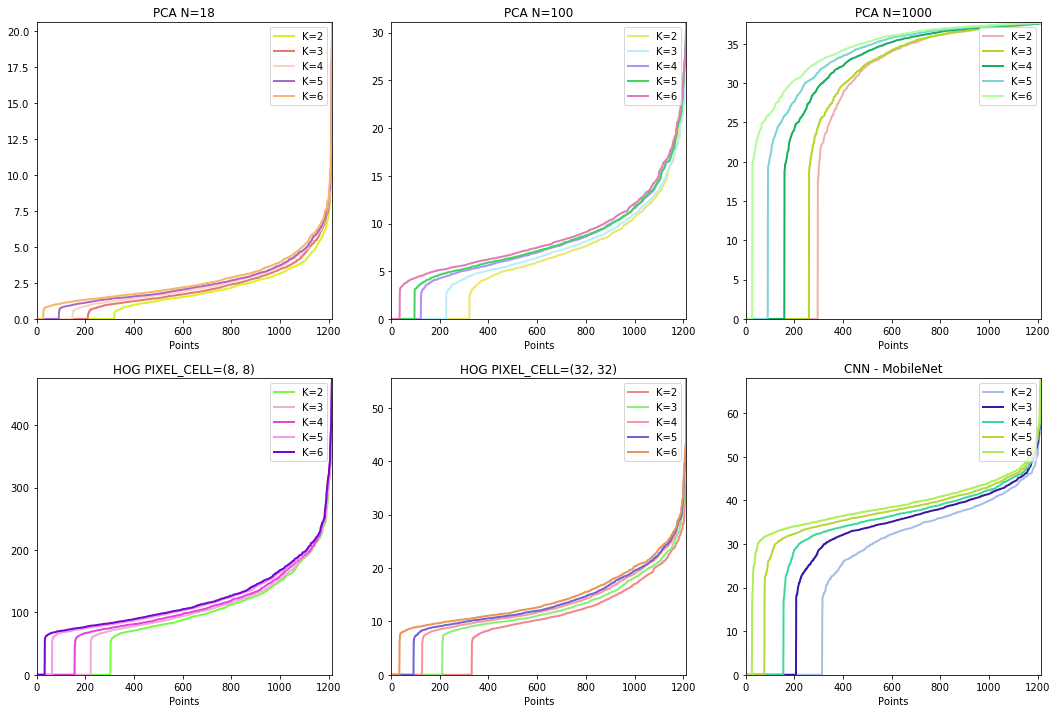

================Best Found Epsilon Value================
              FEATURE SET             EPSILON         K
                 PCA N=18              2.9277         6
                PCA N=100              9.2879         6
               PCA N=1000              27.395         6
    HOG PIXEL_CELL=(8, 8)              128.68         6
  HOG PIXEL_CELL=(32, 32)               15.64         6
          CNN - MobileNet              41.023         6


In [21]:
DBSCAN_CORE_CLUSTER = [2, 3, 4, 5, 6]
BEST_EPSILON = {}
BEST_CORE_CLUSTERS = {}

def dbscan_hyperparameter_tunning(data_model, K):
    dist = DBSCANModel.get_all_distances(data_model.train_features)
    max_k = max(K)
    # get the sorted elements position less than K
    # all elements less the K are in the correct sorted position
    idx = np.argpartition(dist, max_k, axis=1)
    data = []
    names = []
    for k in K:
        # convert to position
        names.append('K={}'.format(k))
        k = k - 1
        ix = idx[:, k]
        data.append(np.sort([dist[i, ix[i]] for i in range(len(ix))]))
    return data, names

PB = mm.PlotBuilder().create_subplots(2, 3, fig_size=(18, 12))
# Search the hyperparameter space for the best model
for feature_set in FEATURE_SETS:
    distances, names = dbscan_hyperparameter_tunning(DATA_MODELS[feature_set], DBSCAN_CORE_CLUSTER)
    BEST_EPSILON[feature_set] = [distances[i][np.argmax(np.abs(np.gradient(distances[i][400:])))]
                                 for i in range(len(DBSCAN_CORE_CLUSTER))]

    PB.create_plot(feature_set, (range(len(DATA_MODELS[feature_set].train_features)), 'Points'),
                   *zip(distances, names))
PB.show()

print('================Best Found Epsilon Value================')
print('{:>25}{:>20}{:>10}'.format('FEATURE SET', 'EPSILON', 'K'))
for feature_set in FEATURE_SETS:
    max_eps_idx = np.argmax(BEST_EPSILON[feature_set])
    eps = BEST_EPSILON[feature_set][max_eps_idx]
    print('{:>25}{:>20.5}{:>10}'.format(feature_set, eps, DBSCAN_CORE_CLUSTER[max_eps_idx]))
    # Set the found values
    BEST_CORE_CLUSTERS[feature_set] = [DBSCAN_CORE_CLUSTER[max_eps_idx]]
    BEST_EPSILON[feature_set] = np.linspace(eps * 0.9, eps * 1.1, num=5)

#### DBSCAN hyperparemeter search
For each selected K and epsilon list try it on all feature sets.

In [22]:
dbscanLookup = {}
# Search the hyperparameter space for the best model
for feature_set in FEATURE_SETS:
    print('--------DBSCAN {}-------'.format(feature_set))
    dbscanLookup[feature_set] = mm.HyperParamsLookup(lambda hyper_params: DBSCANModel(**hyper_params),
                                                     lambda hist: hist['Silhouette Coefficient'])
    dbscanLookup[feature_set].grid_search(DATA_MODELS[feature_set], True, False,
                                          epsilon=BEST_EPSILON[feature_set],
                                          core_cluster_size=BEST_CORE_CLUSTERS[feature_set])

--------DBSCAN PCA N=18-------
Hyperparameters: {'epsilon': 2.6349038333373715, 'core_cluster_size': 6}
Results: 0.22285272149925614
Hyperparameters: {'epsilon': 2.781287379633892, 'core_cluster_size': 6}
Results: 0.24875967117604192
Hyperparameters: {'epsilon': 2.9276709259304132, 'core_cluster_size': 6}
Results: 0.26878908402343943
Hyperparameters: {'epsilon': 3.074054472226934, 'core_cluster_size': 6}
Results: 0.28819746635186133
Hyperparameters: {'epsilon': 3.2204380185234545, 'core_cluster_size': 6}
Results: 0.3064898608679798
--------DBSCAN PCA N=100-------
Hyperparameters: {'epsilon': 8.359091773987199, 'core_cluster_size': 6}
Results: 0.1626680268368331
Hyperparameters: {'epsilon': 8.823485761430932, 'core_cluster_size': 6}
Results: 0.19378010568910525
Hyperparameters: {'epsilon': 9.287879748874666, 'core_cluster_size': 6}
Results: 0.22096098335584333
Hyperparameters: {'epsilon': 9.752273736318399, 'core_cluster_size': 6}
Results: 0.23989424397149497
Hyperparameters: {'epsilon'

#### DBSCAN unsupervised metrics
Plot the unsupervised metrics for each feature set against the performance with differnet number of clusters.

The score and distance metric can be used to do the Elbow method. It should have the elbow where the Silhoutte coefficiente is high

**The X values of the epsilon are not the same but they were plotted together to better highlight differences**

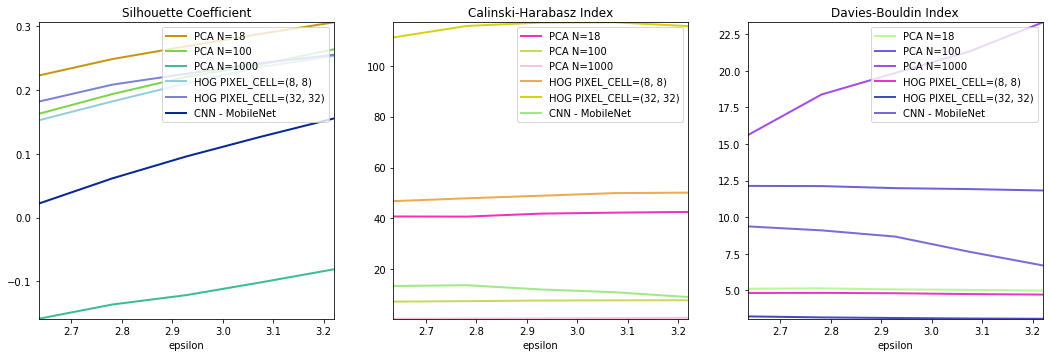

In [23]:
PB = mm.PlotBuilder().create_subplots(2, 3, fig_size=(18, 12))
for metric in ['Silhouette Coefficient', 'Calinski-Harabasz Index', 'Davies-Bouldin Index']:
    show_group_training_history(PB, dbscanLookup, 'epsilon', metric, metric)
PB.show()

#### DBSCAN supervised metrics
Plot the supervised metrics for each feature set against the true Pokemon types in the original set.

Accuracy is also ploted against the random classifier as well as the SVM and CNN model supervised classifiers learned in Project 1.

Notice the outliers is decreasing as we increase epsilon.

**The X values of the epsilon are not the same but they were plotted together to better highlight differences**

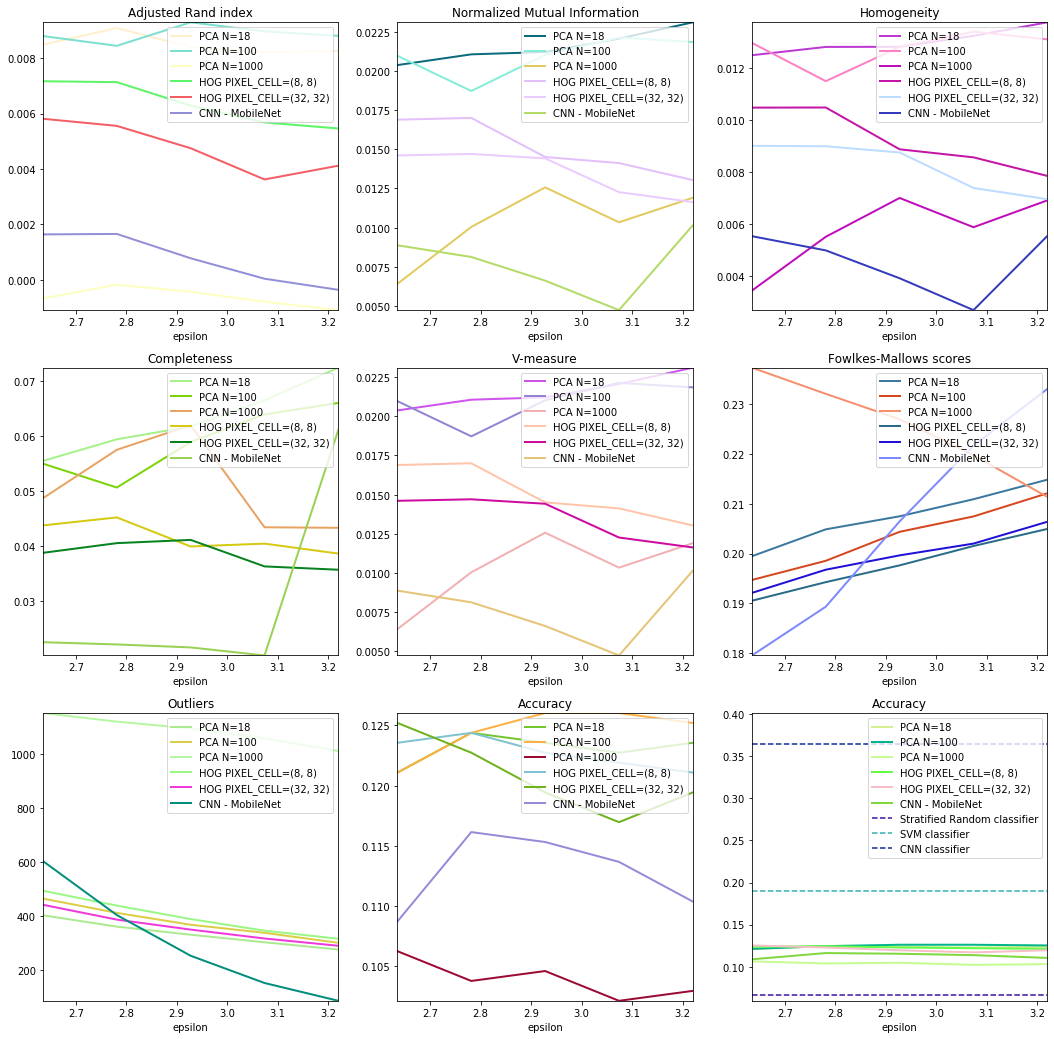

In [24]:
compute_supervised_metrics(dbscanLookup, DATA_MODELS['original'].train_target)

PB = mm.PlotBuilder().create_subplots(3, 3, fig_size=(18, 18))
for metric in ['Adjusted Rand index', 'Normalized Mutual Information', 'Homogeneity',
               'Completeness', 'V-measure', 'Fowlkes-Mallows scores', 'Outliers', 'Accuracy', 'Accuracy']:
    show_group_training_history(PB, dbscanLookup, 'epsilon', metric, metric)
PB.same().create_horizontal_line((0.066, 'Stratified Random classifier'),
                                 (0.19, 'SVM classifier'), (0.365, 'CNN classifier'),
                                 linestyle='--')
PB.show()